In [2]:
import pandas as pd

# Charger le fichier Excel
df = pd.read_csv('olympic_medals.csv')

# Afficher les premières lignes pour vérifier
print(df.head())

   Unnamed: 0 discipline_title     slug_game    event_title event_gender  \
0           0          Curling  beijing-2022  Mixed Doubles        Mixed   
1           1          Curling  beijing-2022  Mixed Doubles        Mixed   
2           2          Curling  beijing-2022  Mixed Doubles        Mixed   
3           3          Curling  beijing-2022  Mixed Doubles        Mixed   
4           4          Curling  beijing-2022  Mixed Doubles        Mixed   

  medal_type participant_type participant_title  \
0       GOLD         GameTeam             Italy   
1       GOLD         GameTeam             Italy   
2     SILVER         GameTeam            Norway   
3     SILVER         GameTeam            Norway   
4     BRONZE         GameTeam            Sweden   

                                         athlete_url     athlete_full_name  \
0  https://olympics.com/en/athletes/stefania-cons...  Stefania CONSTANTINI   
1      https://olympics.com/en/athletes/amos-mosaner          Amos MOSANER   
2 

In [3]:
# Vérifier la structure des données
print(df.columns)

# Renommer les colonnes si nécessaire pour faciliter l'accès
df.columns = ['','discipline_title', 'slug_game', 'event_title', 'event_gender', 'medal_type', 'participant_type', 'participant_title', 'athlete_url', 'athlete_full_name', 'country_name', 'country_code', 'country_3_letter_code']


# Créer un DataFrame avec les médailles agrégées par pays et par année
df_medals = df.groupby(['country_name', 'slug_game', 'medal_type']).size().unstack(fill_value=0).reset_index()

# Renommer les colonnes pour plus de clarté
df_medals.columns = ['country', 'year', 'bronze', 'gold', 'silver']

df_medals['year'] = df_medals['year'].apply(lambda x: int(x.split('-')[-1]))

# Afficher le DataFrame préparé
print(df_medals.head(100))

Index(['Unnamed: 0', 'discipline_title', 'slug_game', 'event_title',
       'event_gender', 'medal_type', 'participant_type', 'participant_title',
       'athlete_url', 'athlete_full_name', 'country_name', 'country_code',
       'country_3_letter_code'],
      dtype='object')
        country  year  bronze  gold  silver
0   Afghanistan  2008       1     0       0
1   Afghanistan  2012       1     0       0
2       Algeria  1996       1     2       0
3       Algeria  1992       1     1       0
4       Algeria  2008       1     0       1
..          ...   ...     ...   ...     ...
95      Austria  1984       1     1       1
96      Austria  1956       4     0       0
97      Austria  1968       3     0       2
98      Austria  1976       1     0       0
99      Austria  1980       1     1       3

[100 rows x 5 columns]


In [4]:
countries = df_medals['country'].unique()
countries
# Réduction du nombre de doublons
for country in countries:
    if 'Soviet Union' in country:
        df_medals['country'].replace(country, 'Russian Federation', inplace=True)        
    elif 'Olympic Athletes from Russia' in country: 
        df_medals['country'].replace(country, 'Russian Federation', inplace=True)
    elif 'Federal Republic of Germany' in country: 
        df_medals['country'].replace(country, 'Germany', inplace=True)   
    elif 'German Democratic Republic (Germany)' in country: 
        df_medals['country'].replace(country, 'Germany', inplace=True)  

In [5]:
countries = df_medals['country'].unique()
i = 0
for country in countries:
    df_medals.loc[df_medals['country'] == country, 'countryId'] = i
    i += 1
df_medals 

,country,year,bronze,gold,silver,countryId
0,Afghanistan,2008,1,0,0,0.0
1,Afghanistan,2012,1,0,0,0.0
2,Algeria,1996,1,2,0,1.0
3,Algeria,1992,1,1,0,1.0
4,Algeria,2008,1,0,1,1.0
...,...,...,...,...,...,...
1774,Zambia,1996,0,0,1,148.0
1775,Zambia,1984,1,0,0,148.0
1776,Zimbabwe,2004,1,1,1,149.0
1777,Zimbabwe,2008,0,1,3,149.0


In [6]:
# Obtenir les 10 meilleurs pays en fonction des médailles totales
top_10_countries = df_medals.groupby('country')[['gold', 'silver', 'bronze']].sum().sort_values(by=['gold', 'silver', 'bronze'], ascending=False).head(10).index
top_10_countries

Index(['United States of America', 'Russian Federation', 'Germany',
       'People's Republic of China', 'Great Britain', 'France', 'Italy',
       'Sweden', 'Norway', 'Hungary'],
      dtype='object', name='country')

### Machine Learning
###### Par année et pays

In [7]:
# Importation de la bibliothèque de machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [8]:
# Séparation des caractéristiques et de la cible
mlX, mly = df_medals[['year', 'countryId']].values, df_medals[['gold', 'silver', 'bronze']].values

In [9]:
# Division des données en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(mlX, mly, test_size=0.30, random_state=0)

In [10]:
# Entrainement du modèle
modelml = RandomForestRegressor(max_depth=10000, random_state=0)
modelml.fit(mlX, mly)

RandomForestRegressor(max_depth=10000, random_state=0)

In [11]:
modelml.predict([[2024, 0]])

array([[0.33, 1.14, 1.06]])

###### Top 10 

In [12]:
topX, topy = df_medals[['year']], df_medals[['countryId', 'bronze', 'gold', 'silver']]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(topX, topy, test_size=0.30, random_state=0)

In [14]:
modeltop = RandomForestRegressor(max_depth=10000, random_state=0)
modeltop.fit(topX, topy)

RandomForestRegressor(max_depth=10000, random_state=0)

In [15]:
modeltop.predict([[2024]])

c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([[73.20981533,  4.06123511,  4.08284844,  4.0313903 ]])

### Time series

In [16]:
pfrance = df_medals.loc[df_medals['country'] == 'France']
pfrance

,country,year,bronze,gold,silver,countryId
554,France,1992,1,3,6,44.0
555,France,1928,5,6,10,44.0
556,France,1920,16,10,19,44.0
557,France,1896,2,5,4,44.0
558,France,2004,14,12,10,44.0
559,France,1996,18,16,7,44.0
560,France,1992,18,9,5,44.0
561,France,2008,22,7,16,44.0
562,France,2022,2,6,7,44.0
563,France,1936,7,7,5,44.0


In [26]:
pfrance = pfrance.drop(['country', 'countryId'], axis=1)
pfrance

KeyError: "['country', 'countryId'] not found in axis"

In [32]:
#pfrance.reset_index(inplace=True)
# pfrance = pfrance.drop(['index', 'level_0'], axis=1)
pfrance = pfrance.set_index('year')
pfrance

,bronze,gold,silver
year,,,
1992,1,3,6
1928,5,6,10
1920,16,10,19
1896,2,5,4
2004,14,12,10
1996,18,16,7
1992,18,9,5
2008,22,7,16
2022,2,6,7


In [34]:
pfrance.sort_values(by='year', inplace=True)
pfrance

,bronze,gold,silver
year,,,
1896,2,5,4
1900,37,28,38
1904,0,0,1
1908,9,6,5
1912,5,8,4
1920,16,10,19
1924,4,0,0
1924,11,14,18
1928,5,6,10


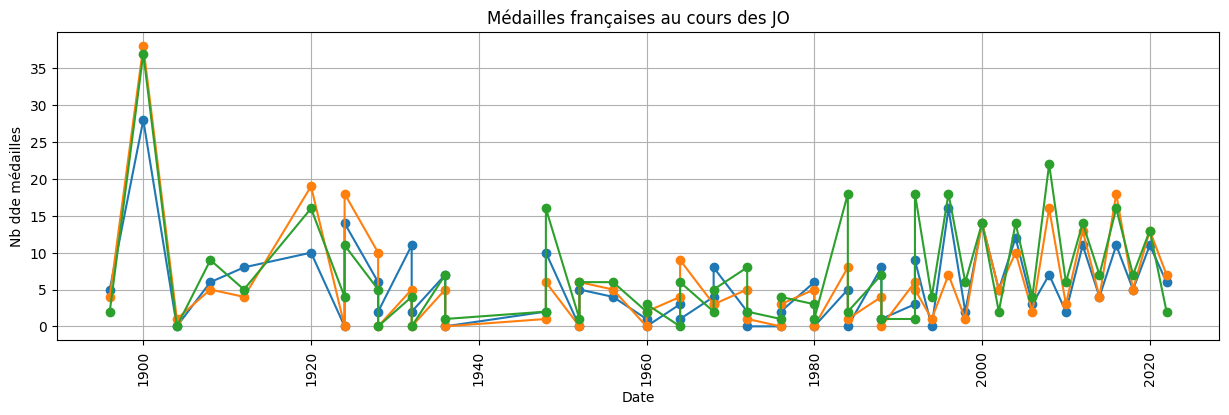

In [35]:
import matplotlib.pyplot as plt
# Création d'un graphique pour visualiser les médailles de la France
plt.figure(figsize=(15, 4))
plt.plot(pfrance[['gold', 'silver', 'bronze']], marker='o', linestyle='-')
plt.gca().set(title='Médailles françaises au cours des JO', xlabel='Date', ylabel='Nb dde médailles')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [40]:
multiplicative_decomposition = seasonal_decompose(pfrance[['gold', 'silver', 'bronze']], model='additif', period=30)

ValueError: x must have 2 complete cycles requires 60 observations. x only has 52 observation(s)

### Enregistrement model

In [18]:
# Importation des bibliothèques
import pickle
import os
# Création d'un dossier s'il n'existe pas
if not os.path.exists('../models'):
    os.mkdir('models')
    pass
# Sauvegarde du modèle
pickle.dump(model, open('../models/medals_model.pkl','wb'))

NameError: name 'model' is not defined